In [1]:
# Package generaux
import ast
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# Packages NLP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

C:\Users\tlp\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Data

In [2]:
df = pd.read_csv(r'data_cleaned/initial_corpus.csv')

print(df.shape)
df.head()

(8918, 8)


,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro
1,Le Monde,Récit Les trois semaines qui ont chamboulé l...,2020-03-27,"Éric Albert, Cécile Boutelet, Jérôme Gautheret...","Londres, Berlin, Rome et Bruxelles corresponda...","- Jeudi 26 mars, les Vingt-Sept devaient se r...","pandémie touche tout le monde, indifféremment ...",Monde
2,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro
3,Le Monde (site web),Coronavirus : les trois semaines qui ont chamb...,2020-03-26,"Eric Albert, Jérôme Gautheret, Cécile Boutelet...","Jeudi 26 mars, les Vingt-Sept doivent se réuni...",n visioconférence pour la troisième fois en mo...,"e la tenue de ses comptes publics, n’est pas s...",Monde
4,Le Monde (site web),Marc Lazar : « Plus l’Italie fait nation face ...,2020-03-25,Marc Lazar,Tribune. L’Italie est le pays qui enregistre à...,date du 25 mars le plus grand nombre de morts...,t de la School of Government de la Luiss (Libr...,Monde


### Création d'un dataset sans les références aux nationalités

On extrait des articles tous les mots qui peuvent influencer le modèle dans son apprentissage

In [3]:
# Liste des pays avec leur nationalité, capitale et continent
pays_nationalite = [
    ("Afghanistan", "Afghan", "Kaboul", "Asie"),
    ("Afrique du Sud", "Sud-africain", "Pretoria", "Afrique"),
    ("Albanie", "Albanais", "Tirana", "Europe"),
    ("Algérie", "Algérien", "Alger", "Afrique"),
    ("Allemagne", "Allemand", "Berlin", "Europe"),
    ("Andorre", "Andorran", "Andorre-la-Vieille", "Europe"),
    ("Angola", "Angolais", "Luanda", "Afrique"),
    ("Antigua-et-Barbuda", "Antiguais", "Saint John's", "Amérique du Nord"),
    ("Arabie saoudite", "Saoudien", "Riyad", "Asie"),
    ("Argentine", "Argentin", "Buenos Aires", "Amérique du Sud"),
    ("Arménie", "Arménien", "Erevan", "Europe"),
    ("Australie", "Australien", "Canberra", "Océanie"),
    ("Autriche", "Autrichien", "Vienne", "Europe"),
    ("Azerbaïdjan", "Azéri", "Bakou", "Europe"),
    ("Zimbabwe", "Zimbabwéen", "Harare", "Afrique"),
    ("Égypte", "Égyptien", "Le Caire", "Afrique"),
    ("Émirats arabes unis", "Émirien", "Abou Dabi", "Asie"),
    ("Équateur", "Équatorien", "Quito", "Amérique du Sud"),
    ("Érythrée", "Érythréen", "Asmara", "Afrique"),
    ("Espagne", "Espagnol", "Madrid", "Europe"),
    ("Estonie", "Estonien", "Tallinn", "Europe"),
    ("États-Unis", "Américain", "Washington", "Amérique du Nord"),
    ("Éthiopie", "Éthiopien", "Addis-Abeba", "Afrique"),
    ("Fidji", "Fidjien", "Suva", "Océanie"),
    ("Finlande", "Finlandais", "Helsinki", "Europe"),
    ("France", "Français", "Paris", "Europe"),
    ("Gabon", "Gabonais", "Libreville", "Afrique"),
    ("Gambie", "Gambien", "Banjul", "Afrique"),
    ("Géorgie", "Géorgien", "Tbilissi", "Europe"),
    ("Ghana", "Ghanéen", "Accra", "Afrique"),
    ("Grèce", "Grec", "Athènes", "Europe"),
    ("Grenade", "Grenadien", "Saint-Georges", "Amérique du Nord"),
    ("Guatemala", "Guatémaltèque", "Guatemala", "Amérique du Nord"),
    ("Guinée", "Guinéen", "Conakry", "Afrique"),
    ("Guinée-Bissau", "Bissau-Guinéen", "Bissau", "Afrique"),
    ("Guinée équatoriale", "Équatoguinéen", "Malabo", "Afrique"),
    ("Guyana", "Guyanais", "Georgetown", "Amérique du Sud"),
    ("Haïti", "Haïtien", "Port-au-Prince", "Amérique du Nord"),
    ("Honduras", "Hondurien", "Tegucigalpa", "Amérique du Nord"),
    ("Hongrie", "Hongrois", "Budapest", "Europe"),
    ("Îles Marshall", "Marshallais", "Majuro", "Océanie"),
    ("Inde", "Indien", "New Delhi", "Asie"),
    ("Indonésie", "Indonésien", "Jakarta", "Asie"),
    ("Irak", "Irakien", "Bagdad", "Asie"),
    ("Iran", "Iranien", "Téhéran", "Asie"),
    ("Irlande", "Irlandais", "Dublin", "Europe"),
    ("Islande", "Islandais", "Reykjavik", "Europe"),
    ("Israël", "Israélien", "Jérusalem", "Asie"),
    ("Italie", "Italien", "Rome", "Europe"),
    ("Jamaïque", "Jamaïcain", "Kingston", "Amérique du Nord"),
    ("Japon", "Japonais", "Tokyo", "Asie"),
    ("Jordanie", "Jordanien", "Amman", "Asie"),
    ("Kazakhstan", "Kazakh", "Noursoultan", "Asie"),
    ("Kenya", "Kényan", "Nairobi", "Afrique"),
    ("Kirghizistan", "Kirghize", "Bichkek", "Asie"),
    ("Kiribati", "Kiribatien", "Tarawa", "Océanie"),
    ("Koweït", "Koweïtien", "Koweït", "Asie"),
    ("Laos", "Laotien", "Vientiane", "Asie"),
    ("Lesotho", "Lesothan", "Maseru", "Afrique"),
    ("Lettonie", "Letton", "Riga", "Europe"),
    ("Liban", "Libanais", "Beyrouth", "Asie"),
    ("Libéria", "Libérien", "Monrovia", "Afrique"),
    ("Libye", "Libyen", "Tripoli", "Afrique"),
    ("Liechtenstein", "Liechtensteinois", "Vaduz", "Europe"),
    ("Lituanie", "Lituanien", "Vilnius", "Europe"),
    ("Luxembourg", "Luxembourgeois", "Luxembourg", "Europe"),
    ("Macédoine du Nord", "Macédonien", "Skopje", "Europe"),
    ("Madagascar", "Malgache", "Antananarivo", "Afrique"),
    ("Malaisie", "Malaisien", "Kuala Lumpur", "Asie"),
    ("Malawi", "Malawien", "Lilongwe", "Afrique"),
    ("Maldives", "Maldivien", "Malé", "Asie"),
    ("Mali", "Malien", "Bamako", "Afrique"),
    ("Malte", "Maltais", "La Valette", "Europe"),
    ("Maroc", "Marocain", "Rabat", "Afrique"),
    ("Maurice", "Mauricien", "Port-Louis", "Afrique"),
    ("Mauritanie", "Mauritanien", "Nouakchott", "Afrique"),
    ("Mexique", "Mexicain", "Mexico", "Amérique du Nord"),
    ("Micronésie", "Micronésien", "Palikir", "Océanie"),
    ("Moldavie", "Moldave", "Chisinau", "Europe"),
    ("Monaco", "Monégasque", "Monaco", "Europe"),
    ("Mongolie", "Mongol", "Oulan-Bator", "Asie"),
    ("Monténégro", "Monténégrin", "Podgorica", "Europe"),
    ("Mozambique", "Mozambicain", "Maputo", "Afrique"),
    ("Namibie", "Namibien", "Windhoek", "Afrique"),
    ("Nauru", "Nauruan", "Yaren", "Océanie"),
    ("Népal", "Népalais", "Katmandou", "Asie"),
    ("Nicaragua", "Nicaraguayen", "Managua", "Amérique du Nord"),
    ("Niger", "Nigérien", "Niamey", "Afrique"),
    ("Nigeria", "Nigérian", "Abuja", "Afrique"),
    ("Niue", "Niuéen", "Alofi", "Océanie"),
    ("Norvège", "Norvégien", "Oslo", "Europe"),
    ("Nouvelle-Zélande", "Néo-zélandais", "Wellington", "Océanie"),
    ("Oman", "Omanais", "Mascate", "Asie"),
    ("Ouganda", "Ougandais", "Kampala", "Afrique"),
    ("Ouzbékistan", "Ouzbek", "Tachkent", "Asie"),
    ("Pakistan", "Pakistanais", "Islamabad", "Asie"),
    ("Palaos", "Palauan", "Ngerulmud", "Océanie"),
    ("Panama", "Panaméen", "Panama", "Amérique du Nord"),
    ("Papouasie-Nouvelle-Guinée", "Papouan-Néo-Guinéen", "Port Moresby", "Océanie"),
    ("Paraguay", "Paraguayen", "Asunción", "Amérique du Sud"),
    ("Pays-Bas", "Néerlandais", "Amsterdam", "Europe"),
    ("Pérou", "Péruvien", "Lima", "Amérique du Sud"),
    ("Philippines", "Philippin", "Manille", "Asie"),
    ("Pologne", "Polonais", "Varsovie", "Europe"),
    ("Portugal", "Portugais", "Lisbonne", "Europe"),
    ("Qatar", "Qatarien", "Doha", "Asie"),
    ("République centrafricaine", "Centrafricain", "Bangui", "Afrique"),
    ("République démocratique du Congo", "Congolais", "Kinshasa", "Afrique"),
    ("République dominicaine", "Dominicain", "Saint-Domingue", "Amérique du Nord"),
    ("République tchèque", "Tchèque", "Prague", "Europe"),
    ("Roumanie", "Roumain", "Bucarest", "Europe"),
    ("Royaume-Uni", "Britannique", "Londres", "Europe"),
    ("Russie", "Russe", "Moscou", "Europe"),
    ("Rwanda", "Rwandais", "Kigali", "Afrique"),
    ("Saint-Christophe-et-Niévès", "Saint-Christophien et Névicien", "Basseterre", "Amérique du Nord"),
    ("Saint-Marin", "Saint-Marinais", "Saint-Marin", "Europe"),
    ("Saint-Vincent-et-les-Grenadines", "Saint-Vincentais et Grenadin", "Kingstown", "Amérique du Nord"),
    ("Sainte-Lucie", "Saint-Lucien", "Castries", "Amérique du Nord"),
    ("Salomon", "Salomonais", "Honiara", "Océanie"),
    ("Salvador", "Salvadorien", "San Salvador", "Amérique du Nord"),
    ("Samoa", "Samoan", "Apia", "Océanie"),
    ("São Tomé-et-Príncipe", "Santoméen", "São Tomé", "Afrique"),
    ("Sénégal", "Sénégalais", "Dakar", "Afrique"),
    ("Serbie", "Serbe", "Belgrade", "Europe"),
    ("Seychelles", "Seychellois", "Victoria", "Afrique"),
    ("Sierra Leone", "Sierra-léonais", "Freetown", "Afrique"),
    ("Singapour", "Singapourien", "Singapour", "Asie"),
    ("Slovaquie", "Slovaque", "Bratislava", "Europe"),
    ("Slovénie", "Slovène", "Ljubljana", "Europe"),
    ("Somalie", "Somalien", "Mogadiscio", "Afrique"),
    ("Soudan", "Soudanais", "Khartoum", "Afrique"),
    ("Soudan du Sud", "Sud-Soudanais", "Djouba", "Afrique"),
    ("Sri Lanka", "Sri-lankais", "Sri Jayawardenapura Kotte", "Asie"),
    ("Suède", "Suédois", "Stockholm", "Europe"),
    ("Suisse", "Suisse", "Berne", "Europe"),
    ("Suriname", "Surinamien", "Paramaribo", "Amérique du Sud"),
    ("Syrie", "Syrien", "Damas", "Asie"),
    ("Swaziland", "Swazilandais", "Mbabane", "Afrique"),
    ("Tadjikistan", "Tadjik", "Douchanbé", "Asie"),
    ("Tanzanie", "Tanzanien", "Dodoma", "Afrique"),
    ("Tchad", "Tchadien", "N'Djaména", "Afrique"),
    ("Thaïlande", "Thaïlandais", "Bangkok", "Asie"),
    ("Timor oriental", "Est-timorais", "Dili", "Asie"),
    ("Togo", "Togolais", "Lomé", "Afrique"),
    ("Tonga", "Tongan", "Nuku'alofa", "Océanie"),
    ("Trinité-et-Tobago", "Trinidadien", "Port-d'Espagne", "Amérique du Nord"),
    ("Tunisie", "Tunisien", "Tunis", "Afrique"),
    ("Turkménistan", "Turkmène", "Achgabat", "Asie"),
    ("Turquie", "Turc", "Ankara", "Europe"),
    ("Tuvalu", "Tuvaluan", "Funafuti", "Océanie"),
    ("Ukraine", "Ukrainien", "Kiev", "Europe"),
    ("Uruguay", "Uruguayen", "Montevideo", "Amérique du Sud"),
    ("Vanuatu", "Vanuatuan", "Port-Vila", "Océanie"),
    ("Vatican", "Vaticanais", "Vatican", "Europe"),
    ("Venezuela", "Vénézuélien", "Caracas", "Amérique du Sud"),
    ("Viêt Nam", "Vietnamien", "Hanoï", "Asie"),
    ("Yémen", "Yéménite", "Sanaa", "Asie"),
    ("Zambie", "Zambien", "Lusaka", "Afrique"),
    ("Zimbabwe", "Zimbabwéen", "Harare", "Afrique")
]

df_pays = pd.DataFrame(pays_nationalite, columns=["Pays", "Nationalité", "Capitale", "Continent"])

display(df_pays.head())
df_pays.shape

,Pays,Nationalité,Capitale,Continent
0,Afghanistan,Afghan,Kaboul,Asie
1,Afrique du Sud,Sud-africain,Pretoria,Afrique
2,Albanie,Albanais,Tirana,Europe
3,Algérie,Algérien,Alger,Afrique
4,Allemagne,Allemand,Berlin,Europe


(159, 4)

In [4]:
# Liste des nationalités
nationalites = [
    "Afghan", "Sud-africain", "Albanais", "Algérien", "Allemand", "Andorran", "Angolais", "Antiguais",
    "Saoudien", "Argentin", "Arménien", "Australien", "Autrichien", "Azéri", "Zimbabwéen", "Égyptien",
    "Émirien", "Équatorien", "Érythréen", "Espagnol", "Estonien", "Américain", "Éthiopien", "Fidjien",
    "Finlandais", "Français", "Gabonais", "Gambien", "Géorgien", "Ghanéen", "Grec", "Grenadien",
    "Guatémaltèque", "Guinéen", "Bissau-Guinéen", "Équatoguinéen", "Guyanais", "Haïtien", "Hondurien",
    "Hongrois", "Marshallais", "Indien", "Indonésien", "Irakien", "Iranien", "Irlandais", "Islandais",
    "Israélien", "Italien", "Jamaïcain", "Japonais", "Jordanien", "Kazakh", "Kényan", "Kirghize",
    "Kiribatien", "Koweïtien", "Laotien", "Lesothan", "Letton", "Libanais", "Libérien", "Libyen",
    "Liechtensteinois", "Lituanien", "Luxembourgeois", "Macédonien", "Malgache", "Malaisien", "Malawien",
    "Maldivien", "Malien", "Maltais", "Marocain", "Mauricien", "Mauritanien", "Mexicain", "Micronésien",
    "Moldave", "Monégasque", "Mongol", "Monténégrin", "Mozambicain", "Namibien", "Nauruan", "Népalais",
    "Nicaraguayen", "Nigérien", "Nigérian", "Niuéen", "Norvégien", "Néo-zélandais", "Omanais", "Ougandais",
    "Ouzbek", "Pakistanais", "Palauan", "Panaméen", "Papouan-Néo-Guinéen", "Paraguayen", "Néerlandais",
    "Péruvien", "Philippin", "Polonais", "Portugais", "Qatarien", "Centrafricain", "Congolais", "Dominicain",
    "Tchèque", "Roumain", "Britannique", "Russe", "Rwandais", "Saint-Christophien et Névicien", "Saint-Marinais",
    "Saint-Vincentais et Grenadin", "Saint-Lucien", "Salomonais", "Salvadorien", "Samoan", "Santoméen",
    "Sénégalais", "Serbe", "Seychellois", "Sierra-léonais", "Singapourien", "Slovaque", "Slovène",
    "Somalien", "Soudanais", "Sud-Soudanais", "Sri-lankais", "Suédois", "Suisse", "Surinamien", "Syrien",
    "Swazilandais", "Tadjik", "Tanzanien", "Tchadien", "Thaïlandais", "Est-timorais", "Togolais", "Tongan",
    "Trinidadien", "Tunisien", "Turkmène", "Turc", "Tuvaluan", "Ukrainien", "Uruguayen", "Vanuatuan",
    "Vaticanais", "Vénézuélien", "Vietnamien", "Yéménite", "Zambien", "Zimbabwéen"
]

# Fonction pour générer les différentes formes des adjectifs de nationalité
def generer_formes(nationalite):
    masculin_singulier = nationalite
    masculin_pluriel = nationalite + "s"
    feminin_singulier = nationalite + "e"
    feminin_pluriel = nationalite + "es"
    return masculin_singulier, masculin_pluriel, feminin_singulier, feminin_pluriel

df_nationalites = pd.DataFrame(nationalites, columns=["Nationalité"])
df_nationalites["Masculin Singulier"], df_nationalites["Masculin Pluriel"], df_nationalites["Féminin Singulier"], df_nationalites["Féminin Pluriel"] = zip(*df_nationalites["Nationalité"].apply(generer_formes))

display(df_nationalites.head())
df_nationalites.shape

,Nationalité,Masculin Singulier,Masculin Pluriel,Féminin Singulier,Féminin Pluriel
0,Afghan,Afghan,Afghans,Afghane,Afghanes
1,Sud-africain,Sud-africain,Sud-africains,Sud-africaine,Sud-africaines
2,Albanais,Albanais,Albanaiss,Albanaise,Albanaises
3,Algérien,Algérien,Algériens,Algériene,Algérienes
4,Allemand,Allemand,Allemands,Allemande,Allemandes


(159, 5)

In [ ]:
# Stockage des nationalites
#df_nationalites.to_csv('all_nationalities.csv')

On va maintenant pouvoir extraire toutes les infos relatives aux nationalités :
- en utilisant les dataframes précédents sur les pays et nationalités
- en utilisant spacy qui permet en plus d'identifier des mots plus spécifiques mais révélateurs  
    ex. religion (islam, christianisme, etc.), ethnie (arabes, etc.), etc.

In [5]:
# Import du module de Spacy pour des corpus français
nlp = spacy.load("fr_core_news_sm")

In [6]:
nationalities = pd.concat([df_nationalites[col].apply(lambda x : x.lower()) for col in df_nationalites.columns]).unique()

# Fonction pour extraire les mots et les remplacer arbitrairement par "PAMPLEMOUSSE"
def replace_nationality_entities(text):
    doc = nlp(text)
    replaced_text = []
    replaced_words = []  # Nouvelle liste pour stocker les mots remplacés
    for token in doc:
        if token.ent_type_ == "LOC" or token.ent_type_ == "GPE" or str(token).lower() in nationalities:
            replaced_text.append("PAMPLEMOUSSE")
            replaced_words.append(token.text)  # Ajouter le mot remplacé à la liste
        else:
            replaced_text.append(token.text)
    return " ".join(replaced_text), replaced_words

In [ ]:
for journal in tqdm(df.CJournal.unique()):
    d = df.loc[df.CJournal == journal].copy()
    d[["texte_processed", "replaced_words"]] = d["Texte"].apply(lambda x: pd.Series(replace_nationality_entities(x)))
    
    display(d.head())
    #d.to_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_'+journal+'.csv',sep=";", index=False)


In [24]:
# Assemblage final
final = pd.concat([
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Figaro.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Monde.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Libération.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Croix.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Parisien.csv',sep=";"),
    pd.read_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE_Echos.csv',sep=";")
])

In [25]:
# Stockage final
#final.to_csv('data_cleaned/corpus_cleaned_PAMPLEMOUSSE.csv',sep=";", index=False)

# NLP humanitaire vs securitaire

In [3]:
# Données annotées
gs_intial = pd.read_csv('./data_cleaned/gold_standard_annote.csv').drop(["is_humanitaire_check","is_securitaire_check","disagreement"], axis=1)
gs_complement = pd.read_csv('./data_cleaned/gold_standard_annote_complement.csv')

gs = pd.concat([gs_intial, gs_complement])
gs.head()

,Journal,Titre,Date,Auteur,Texte,is_humanitaire,is_securitaire,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words,annee
0,"La Croix, no. 40303",VU D'ITALIE Matteo Renzi veut un budget « en e...,2015-10-01,DANCER Marie,La saison budgétaire bat son plein en Europe. ...,0,0,me la France et les autres pays de la zone eur...,"ns le même temps, l'Italie réclame, comme l'Au...",Croix,La saison budgétaire bat son plein en PAMPLEMO...,"['Europe', 'la', 'France', ""l'"", 'Italie', 'Br...",2015
1,"La Croix, no. 40331","Ankara, partenaire incontournable des Européen...",2015-11-03,LE TALLEC Camille,BRUXELLES De notre correspondante Avec rés...,0,0,"e et sobriété, l'Union européenne a réagi aux ...","moment » , estimait de son côté le chef de l'...",Croix,BRUXELLES De notre correspondante Avec r...,"['Turquie', 'Bruxelles', 'Ankara', 'Turquie', ...",2015
2,"La Croix, no. 40327","Jeunes, réfugiés et vulnérables L'Autriche ve...",2015-10-29,VERDIER Marie,La longue route des migrants fluctue au gré de...,1,1,ermetures de frontière. À mesure que la Hongri...,semigratoire est susceptible de « provoquer u...,Croix,La longue route des migrants fluctue au gré de...,"['Hongrie', 'Serbie', 'Croatie', 'Grèce', 'Oue...",2015
3,"La Croix, no. 40341",Éditorial Ensemble,2015-11-16,GOUBERT Guillaume,"Depuis vendredi, la menace terroriste en Franc...",0,1,complètement changé de dimension. Ce que les s...,symbole serait que la France bénéficie de renf...,Croix,"Depuis vendredi , la menace terroriste en PAMP...","['France', 'La', 'France', 'Sahel', 'Proche', ...",2015
4,"La Croix, no. 40529",Entretien « Réduire la distance entre les élit...,2016-06-28,PLOQUIN Jean-Christophe,Qu'est-ce qui explique le malaise d'une partie...,0,1,s Européens vis-à-vis de la construction europ...,ui resterait ouverte à d'autres qui voudraient...,Croix,Qu' est -ce qui explique le malaise d' une par...,"['Européens', 'Portugal', 'Espagne', 'Italie',...",2016


### Entrainement

Nous avons testé différents modèles (Random, Forest, Logistic Regression, Naive Bayes) et plusieurs paramètres pour chacun. Les meilleurs résultats sont obtenus pour chaque catégorie par l'estimateur baysien avec une précision de 0.78 pour les articles humanitaires et 0.73 pour les articles sécuritaires.

In [4]:
# Division des données en train et tes set
X_train, X_test, y_train, y_test = train_test_split(gs['texte_processed'], gs[['is_humanitaire', 'is_securitaire']], test_size=0.2, random_state=42)

clf_humanitaire = MultinomialNB(alpha=.3)
clf_securitaire = MultinomialNB(alpha=.3)

for category, classifieur in [
    ["is_humanitaire",clf_humanitaire],
    ["is_securitaire",clf_securitaire]
] :
    # Création d'un vecteur de comptage pour transformer les textes en matrices de fréquence de mots
    vectorizer = CountVectorizer()

    # Transformation des textes d'entraînement et de test
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)

    # Entrainement et test de performance
    classifieur.fit(X_train_vect, y_train[category])
    y_pred_humanitaire =classifieur.predict(X_test_vect)
    
    print(f"\n Résultats détaillés pour {category}")
    print(classification_report(y_test[category], y_pred_humanitaire))


 Résultats détaillés pour is_humanitaire
              precision    recall  f1-score   support

           0       0.86      0.72      0.78        53
           1       0.57      0.77      0.66        26

    accuracy                           0.73        79
   macro avg       0.72      0.74      0.72        79
weighted avg       0.77      0.73      0.74        79


 Résultats détaillés pour is_securitaire
              precision    recall  f1-score   support

           0       0.77      0.57      0.66        35
           1       0.72      0.86      0.78        44

    accuracy                           0.73        79
   macro avg       0.74      0.72      0.72        79
weighted avg       0.74      0.73      0.73        79



# Application

In [5]:
df_cleaned = pd.read_csv('./data_cleaned/corpus_cleaned_PAMPLEMOUSSE.csv',sep=";")
df_cleaned["Année"] = df.Date.apply(lambda x: x[:4])
df_cleaned.head()

,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words,Année
0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,"['Rome', 'Bergame', 'russe', 'italien', 'De', ...",2020
1,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro,Fin observateur de la vie politique PAMPLEMOUS...,"['française', 'États', 'l’', 'Macédoine', 'du'...",2020
2,Le Figaro (site web),"Coronavirus, un révélateur des faiblesses de l...",2020-03-12,"Long, Didier, Laye, Sébastien",Didier Long est physicien. Sébastien Laye est ...,"repreneur dans l’immobilier, chercheur associé...",faire un choix clair: l’idéologie rigoriste as...,Figaro,Didier Long est physicien . Sébastien Laye est...,"['l’', 'Chine', 'l’', 'région', 'de', 'Wuhan',...",2020
3,"Le Figaro, no. 23505",EN BREF,2020-03-12,"Portes, Thierry",Collision entre un navire grec et un patrouill...,turc Les garde-côtes grecs ont déclaré qu'un ...,"en Afghanistan, ouvrant la voie à des pourparl...",Figaro,Collision entre un navire PAMPLEMOUSSE et un p...,"['grec', 'turc', 'grecs', 'turc', 'turc', ""l'""...",2020
4,Le Figaro (site web),Coralie Delaume: «Un choc externe pourrait pro...,2020-03-11,"Imad, Joachim",Coralie Delaume est essayiste. Elle a notammen...,crit Le Couple franco-allemand n’existe pas (M...,on approche du la fin. De celle de l’Union eur...,Figaro,Coralie Delaume est essayiste . Elle a notamme...,"['FIGAROVOX.-', 'italien', 'l’', 'Quelles', 'l...",2020


In [6]:
# Application
print("Prediction is_humanitaire")
df_cleaned["is_humanitaire_pred"] = clf_humanitaire.predict(vectorizer.transform(df_cleaned["texte_processed"]))
print("Prediction is_securitaire")
df_cleaned["is_securitaire_pred"] = clf_securitaire.predict(vectorizer.transform(df_cleaned["texte_processed"]))
print("Done")

Prediction is_humanitaire
Prediction is_securitaire
Done


In [9]:
# Stockage
#df_cleaned.to_csv('./data_cleaned/corpus_cleaned_PAMPLEMOUSSE_predicted.csv',sep=";",index=False)

In [7]:
# Stat desc
display(df_cleaned[["CJournal","is_humanitaire_pred","is_securitaire_pred"]].groupby(["is_humanitaire_pred","is_securitaire_pred"]).count())
       
display(df_cleaned[["CJournal","Texte","is_humanitaire_pred","is_securitaire_pred"]].groupby(["CJournal","is_humanitaire_pred","is_securitaire_pred"]).count())

CJournal
is_humanitaire_pred is_securitaire_pred          
0                   0                        2090
                    1                        2749
1                   0                         917
                    1                        3162

Texte
CJournal   is_humanitaire_pred is_securitaire_pred       
Croix      0                   0                      131
                               1                      191
           1                   0                      138
                               1                      337
Echos      0                   0                      342
                               1                      462
           1                   0                       73
                               1                      387
Figaro     0                   0                      715
                               1                      999
           1                   0                      247
                               1                     1069
Libération 0                   0                      220
                               1                      205
           1                   0                      109
                               1                      372
Monde      0                   0                      558
                               1                      751
           1                   0                      208
                               1                      715
Parisien   0                   0                      124
                               1                      141
           1                   0                      142
                               1                      282

Proportion d'articles classés comme humanitaires et sécuritaires :
Humanitaires : 45.74%
Sécuritaires : 66.28%

Analyse par journaux :


,is_humanitaire_pred,is_securitaire_pred
CJournal,,
Croix,0.595985,0.662484
Echos,0.361600,0.671200
Figaro,0.434323,0.682508
Libération,0.531532,0.634009
Monde,0.413530,0.656810
Parisien,0.615385,0.613933



Analyse par années :


,is_humanitaire_pred,is_securitaire_pred
Année,,
2015,0.516690,0.727315
2016,0.392379,0.677554
2017,0.369990,0.568345
2018,0.411685,0.658288
2019,0.415842,0.582921
2020,0.607798,0.651376
2021,0.666667,0.679012
2022,0.653061,0.586735


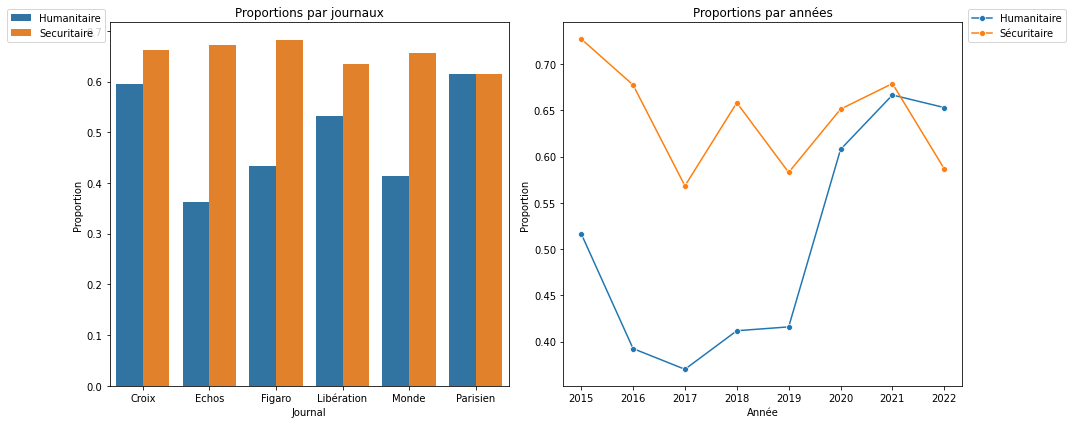

In [8]:
# Analyser la proportion d'articles de chaque type
print("Proportion d'articles classés comme humanitaires et sécuritaires :")
prop_humanitaire = df_cleaned['is_humanitaire_pred'].mean()
prop_securitaire = df_cleaned['is_securitaire_pred'].mean()
print(f"Humanitaires : {round(prop_humanitaire * 100,2)}%")
print(f"Sécuritaires : {round(prop_securitaire * 100,2)}%")

# Segmentation par journaux
print("\nAnalyse par journaux :")
grouped_by_journal = df_cleaned.loc[df_cleaned["Année"]>"2014"].groupby('CJournal')
journal_analysis = grouped_by_journal.agg({
    'is_humanitaire_pred': 'mean',
    'is_securitaire_pred': 'mean'
})
display(journal_analysis)

# Segmentation par années
print("\nAnalyse par années :")
df_cleaned["Année"] = df_cleaned["Date"].apply(lambda x: x[:4])
grouped_by_year = df_cleaned.loc[df_cleaned["Année"]>"2014"].groupby('Année')
year_analysis = grouped_by_year.agg({
    'is_humanitaire_pred': 'mean',
    'is_securitaire_pred': 'mean'
})
display(year_analysis)

# Visualisation des proportions d'articles classés humanitaires et sécuritaires
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
data_formated = pd.melt(journal_analysis.reset_index().rename(columns={"is_humanitaire_pred":"Humanitaire","is_securitaire_pred":"Securitaire"}), id_vars=['CJournal'], var_name='categories', value_name='proportion').rename(columns={"is_humanitaire_pred":"Humanitaire","is_securitaire_pred":"Securitaire"})
sns.barplot(data_formated, x="CJournal", y="proportion", hue="categories")
plt.title("Proportions par journaux")
plt.xlabel("Journal")
plt.ylabel("Proportion")
plt.legend(bbox_to_anchor=(0.001, 1.05), loc='upper right')

plt.subplot(1, 2, 2)
sns.lineplot(x=year_analysis.index, y='is_humanitaire_pred', data=year_analysis, label='Humanitaire', marker='o')
sns.lineplot(x=year_analysis.index, y='is_securitaire_pred', data=year_analysis, label='Sécuritaire', marker='o')
plt.title("Proportions par années")
plt.xlabel("Année")
plt.ylabel("Proportion")
plt.legend(bbox_to_anchor=(1.001, 1.05), loc='upper left')

plt.tight_layout()
plt.show()


In [10]:
#Stockage
#journal_analysis.to_csv('./data_cleaned/resultats_classification_journal.csv',sep=";",index=False)
#year_analysis.to_csv('./data_cleaned/resultats_classification_annee.csv',sep=";",index=False)

# Analyse des nationalités 

Dans cette partie on analyse les nationalités les plus présentes par type d'article, humanitaire ou sécuritaire.
Les résultats ne sont malheuresement pas particulièrement intéressant

In [28]:
# On passe toutes les valeurs en minuscule
df_nationalites = df_nationalites.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df_pays = df_pays.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [31]:
# On teste toutes les nationalités possibles et leurs extansions
df_cleaned['replaced_words'] = df_cleaned.replaced_words.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
word_to_eliminate = ["l'","la","de","-","l'","l'","l’","la","le"]
L = []
for replaced_words in tqdm(df_cleaned.replaced_words) :
    l = []
    for word in replaced_words :
        word = word.lower()
        if word in df_nationalites["Masculin Singulier"].unique() :
            word = df_nationalites.loc[df_nationalites["Masculin Singulier"]==word,"Nationalité"].iloc[0]
        elif word in df_nationalites["Masculin Pluriel"].unique() :
            word = df_nationalites.loc[df_nationalites["Masculin Pluriel"]==word,"Nationalité"].iloc[0]
        elif word in df_nationalites["Féminin Singulier"].unique() :
            word = df_nationalites.loc[df_nationalites["Féminin Singulier"]==word,"Nationalité"].iloc[0]
        elif word in df_nationalites["Féminin Pluriel"].unique() :
            word = df_nationalites.loc[df_nationalites["Féminin Pluriel"]==word,"Nationalité"].iloc[0]
        else :
            if word in df_pays["Capitale"].unique() :
                word = df_pays.loc[df_pays["Capitale"]==word,"Nationalité"].iloc[0]
            if word in df_pays["Pays"].unique() :
                word = df_pays.loc[df_pays["Pays"]==word,"Nationalité"].iloc[0]

        l.append(word)
    
    L.append(l)       

100%|██████████████████████████████████████████████████████████████████████████████| 8918/8918 [06:31<00:00, 22.78it/s]


In [32]:
df_cleaned["replaced_words_cleaned"] = pd.Series(L)
df_cleaned.head()

,Unnamed: 0,Journal,Titre,Date,Auteur,Texte,extrait_debut,extrait_fin,CJournal,texte_processed,replaced_words,Année,replaced_words_cleaned
0,0,"Le Figaro, no. 23520",L'agenda caché de Moscou en Italie,2020-03-30,"Lasserre, Isabelle",LES SYMBOLES comptent parfois plus que les fai...,"Sur les camions militaires qui, en colonnes, ...",Deux semaines pour se ressaisir et s'unir ou p...,Figaro,LES SYMBOLES comptent parfois plus que les fai...,"[Rome, Bergame, russe, italien, De, Russie, Ch...",2020,"[italien, bergame, russe, italien, de, russe, ..."
1,1,Le Figaro (site web),Élargissement de l’Union européenne à l’heure ...,2020-03-26,"Tandonnet, Maxime",Fin observateur de la vie politique française ...,"contributeur régulier du FigaroVox, Maxime Tan...",es yeux et de se préparer au changement d’un m...,Figaro,Fin observateur de la vie politique PAMPLEMOUS...,"[française, États, l’, Macédoine, du, Nord, Ba...",2020,"[français, états, l’, macédoine, du, nord, bal..."
2,2,Le Figaro (site web),"Coronavirus, un révélateur des faiblesses de l...",2020-03-12,"Long, Didier, Laye, Sébastien",Didier Long est physicien. Sébastien Laye est ...,"repreneur dans l’immobilier, chercheur associé...",faire un choix clair: l’idéologie rigoriste as...,Figaro,Didier Long est physicien . Sébastien Laye est...,"[l’, Chine, l’, région, de, Wuhan, l’, l’, Eur...",2020,"[l’, chine, l’, région, de, wuhan, l’, l’, eur..."
3,3,"Le Figaro, no. 23505",EN BREF,2020-03-12,"Portes, Thierry",Collision entre un navire grec et un patrouill...,turc Les garde-côtes grecs ont déclaré qu'un ...,"en Afghanistan, ouvrant la voie à des pourparl...",Figaro,Collision entre un navire PAMPLEMOUSSE et un p...,"[grec, turc, grecs, turc, turc, l', Europe, ru...",2020,"[grec, turc, grec, turc, turc, l', europe, rus..."
4,4,Le Figaro (site web),Coralie Delaume: «Un choc externe pourrait pro...,2020-03-11,"Imad, Joachim",Coralie Delaume est essayiste. Elle a notammen...,crit Le Couple franco-allemand n’existe pas (M...,on approche du la fin. De celle de l’Union eur...,Figaro,Coralie Delaume est essayiste . Elle a notamme...,"[FIGAROVOX.-, italien, l’, Quelles, l’, l’, l’...",2020,"[figarovox.-, italien, l’, quelles, l’, l’, l’..."


In [26]:
#df_cleaned=pd.read_csv('./data_cleaned/df_cleaned_v2.csv')

In [38]:
stat = pd.DataFrame()

for journal in df_cleaned["CJournal"].unique() :
    print(f"Traitement de {journal}")
    df = df_cleaned.loc[df_cleaned.CJournal==journal]
    
    for year in df["Année"].unique():
        print(year)
        data = df.loc[df["Année"]==year]
        
        ##############################
        ### Metriques sur les mots ###
        ##############################
        
        # Dictionnaires pour récupérer les métriques
        dict_humanitaire = {}
        dict_securitaire = {}
        
        ### Boucles sur les mots qu'on a extrait des artciles
        # Cas humanitaire
        for replaced_words in np.array(data.loc[data["is_humanitaire_pred"]==1, "replaced_words_cleaned"]) :
            for word in replaced_words :
                word = word.lower()
                # On compte dans les dictionnaires
                if word not in dict_humanitaire.keys():
                    dict_humanitaire[word] = 1
                else :
                    dict_humanitaire[word] += 1
        
        # Cas sécuritaire
        for replaced_words in np.array(data.loc[data["is_securitaire_pred"]==1, "replaced_words_cleaned"]) :
            for word in replaced_words :
                word = word.lower()
                # On compte dans les dictionnaires        
                if word not in dict_securitaire.keys():
                    dict_securitaire[word] = 1
                else :
                    dict_securitaire[word] += 1

        # Convertion les dictionnaires en dataframes
        df_huma = pd.DataFrame(list(dict_humanitaire.items()), columns=['mots', 'occurence_huma'])
        df_secu = pd.DataFrame(list(dict_securitaire.items()), columns=['mots', 'occurence_secu'])

        # Fusion les deux dataframes sur la colonne "mots"
        result_df = pd.merge(df_huma, df_secu, on='mots', how='outer')

        ##################################
        ### Metriques sur les articles ###
        ##################################
        
        print("Process nombre d'article")
        dict_humanitaire = {}
        dict_securitaire = {}

        for word in result_df.mots :            
            for replaced_words in data.loc[data["is_humanitaire_pred"]==1, "replaced_words_cleaned"] :
                word = word.lower()
                if word in replaced_words :  
                    if word not in dict_humanitaire.keys():
                        dict_humanitaire[word] = 1
                    else :
                        dict_humanitaire[word] += 1

            for replaced_words in data.loc[data["is_securitaire_pred"]==1, "replaced_words_cleaned"] :
                word = word.lower()
                if word in replaced_words : 
                    if word not in dict_securitaire.keys():
                        dict_securitaire[word] = 1
                    else :
                        dict_securitaire[word] += 1
    
        df_huma = pd.DataFrame(list(dict_humanitaire.items()), columns=['mots', 'articles_huma'])
        df_secu = pd.DataFrame(list(dict_securitaire.items()), columns=['mots', 'articles_secu'])

        result_df = pd.merge(result_df, df_huma, on='mots', how='left')
        result_df = pd.merge(result_df, df_secu, on='mots', how='left')

        # Remplacement des valeurs manquantes par 0
        result_df = result_df.fillna(0)
        result_df.insert(0,"journal",journal)
        result_df.insert(1,"annees",year)
        
        stat = pd.concat([
            stat,
            result_df
        ])
    
            

Traitement de Figaro
2020
Process nombre d'article
2019
Process nombre d'article
2018
Process nombre d'article
2017
Process nombre d'article
2016
Process nombre d'article
2015
Process nombre d'article
2014
Process nombre d'article
2013
Process nombre d'article
2011
Process nombre d'article
2022
Process nombre d'article
2021
Process nombre d'article
Traitement de Monde
2020
Process nombre d'article
2019
Process nombre d'article
2018
Process nombre d'article
2017
Process nombre d'article
2016
Process nombre d'article
2015
Process nombre d'article
2014
Process nombre d'article
2012
Process nombre d'article
2010
Process nombre d'article
2009
Process nombre d'article
2022
Process nombre d'article
2021
Process nombre d'article
Traitement de Libération
2020
Process nombre d'article
2019
Process nombre d'article
2018
Process nombre d'article
2017
Process nombre d'article
2016
Process nombre d'article
2015
Process nombre d'article
2014
Process nombre d'article
2013
Process nombre d'article
2011

In [36]:
# Stockage 
#stat.to_csv('./data_cleaned/stat_nat_huma_secu.csv')

In [39]:
stat
for journal in stat.journal.unique():
    print(journal, "Humanitaire")
    display(stat.loc[stat.journal == journal].sort_values(by=["occurence_huma"], ascending=False).head(5))
    
    print(journal, "Securitaire")
    display(stat.loc[stat.journal == journal].sort_values(by=["occurence_secu"], ascending=False).head(5))

Figaro Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
0,Figaro,2015,allemand,699.0,1182.0,196.0,292.0
168,Figaro,2016,turc,648.0,1275.0,114.0,231.0
19,Figaro,2015,europe,576.0,961.0,232.0,331.0
0,Figaro,2016,français,574.0,1277.0,162.0,305.0
12,Figaro,2015,français,550.0,1024.0,172.0,278.0


Figaro Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
70,Figaro,2016,allemand,386.0,1399.0,118.0,318.0
0,Figaro,2016,français,574.0,1277.0,162.0,305.0
168,Figaro,2016,turc,648.0,1275.0,114.0,231.0
17,Figaro,2016,europe,446.0,1236.0,181.0,361.0
0,Figaro,2015,allemand,699.0,1182.0,196.0,292.0


Monde Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
34,Monde,2015,français,664.0,1142.0,159.0,262.0
4,Monde,2016,français,609.0,1178.0,162.0,307.0
206,Monde,2016,grec,593.0,773.0,123.0,192.0
21,Monde,2015,allemand,566.0,1060.0,155.0,247.0
54,Monde,2016,turc,560.0,979.0,134.0,187.0


Monde Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
1,Monde,2016,europe,540.0,1382.0,169.0,333.0
4,Monde,2016,français,609.0,1178.0,162.0,307.0
34,Monde,2015,français,664.0,1142.0,159.0,262.0
16,Monde,2016,allemand,370.0,1137.0,132.0,279.0
21,Monde,2015,allemand,566.0,1060.0,155.0,247.0


Libération Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
46,Libération,2018,français,347.0,384.0,71.0,93.0
38,Libération,2018,italien,287.0,419.0,53.0,81.0
12,Libération,2015,français,273.0,358.0,58.0,79.0
33,Libération,2016,grec,262.0,295.0,28.0,39.0
3,Libération,2016,europe,194.0,279.0,54.0,71.0


Libération Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
38,Libération,2018,italien,287.0,419.0,53.0,81.0
46,Libération,2018,français,347.0,384.0,71.0,93.0
12,Libération,2015,français,273.0,358.0,58.0,79.0
32,Libération,2018,l',188.0,309.0,65.0,99.0
49,Libération,2018,allemand,133.0,307.0,40.0,73.0


Croix Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
17,Croix,2018,français,363.0,342.0,66.0,67.0
25,Croix,2018,italien,196.0,235.0,48.0,56.0
0,Croix,2020,turc,190.0,188.0,26.0,25.0
4,Croix,2020,grec,173.0,170.0,28.0,26.0
33,Croix,2018,l',156.0,208.0,55.0,72.0


Croix Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
17,Croix,2018,français,363.0,342.0,66.0,67.0
83,Croix,2016,turc,96.0,267.0,19.0,37.0
79,Croix,2018,allemand,139.0,253.0,31.0,51.0
25,Croix,2018,italien,196.0,235.0,48.0,56.0
32,Croix,2018,europe,151.0,226.0,54.0,72.0


Parisien Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
32,Parisien,2015,français,404.0,475.0,83.0,99.0
103,Parisien,2015,hongrois,374.0,379.0,39.0,44.0
73,Parisien,2015,allemand,344.0,383.0,59.0,69.0
3,Parisien,2015,europe,289.0,329.0,82.0,93.0
5,Parisien,2015,syrien,269.0,308.0,68.0,75.0


Parisien Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
32,Parisien,2015,français,404.0,475.0,83.0,99.0
73,Parisien,2015,allemand,344.0,383.0,59.0,69.0
103,Parisien,2015,hongrois,374.0,379.0,39.0,44.0
3,Parisien,2015,europe,289.0,329.0,82.0,93.0
5,Parisien,2015,syrien,269.0,308.0,68.0,75.0


Echos Humanitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
18,Echos,2015,allemand,481.0,758.0,98.0,163.0
79,Echos,2016,turc,385.0,756.0,64.0,124.0
8,Echos,2015,français,340.0,555.0,78.0,133.0
6,Echos,2015,europe,316.0,531.0,113.0,181.0
13,Echos,2015,hongrois,256.0,285.0,60.0,76.0


Echos Securitaire


,journal,annees,mots,occurence_huma,occurence_secu,articles_huma,articles_secu
18,Echos,2015,allemand,481.0,758.0,98.0,163.0
79,Echos,2016,turc,385.0,756.0,64.0,124.0
13,Echos,2016,allemand,155.0,593.0,70.0,161.0
20,Echos,2016,europe,248.0,585.0,96.0,183.0
8,Echos,2015,français,340.0,555.0,78.0,133.0


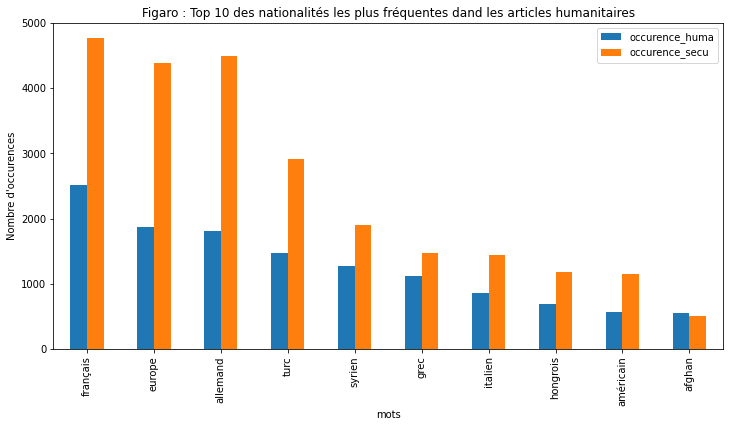

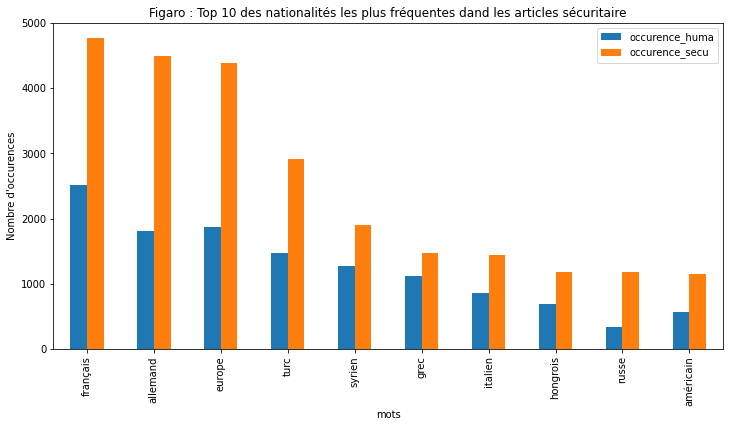

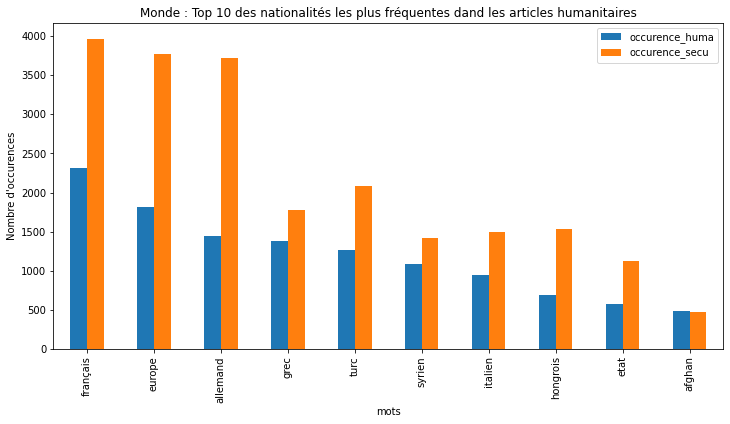

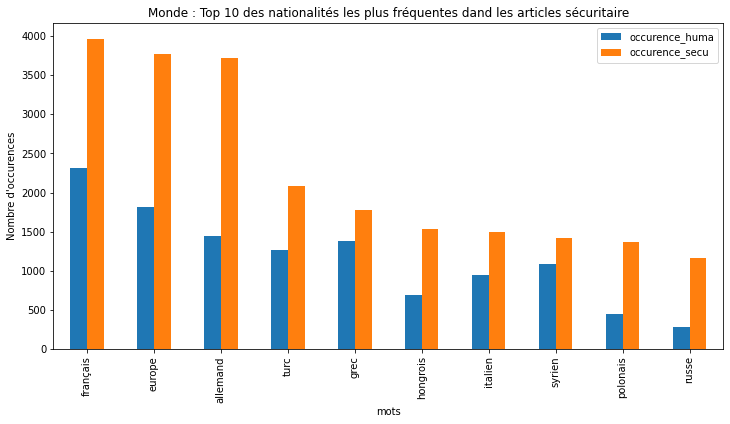

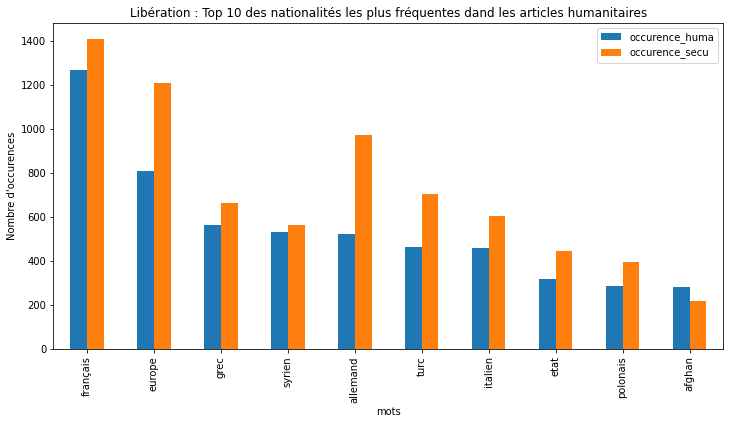

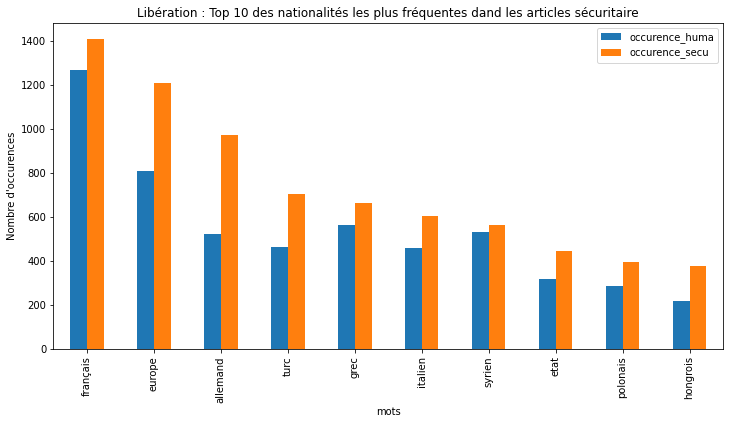

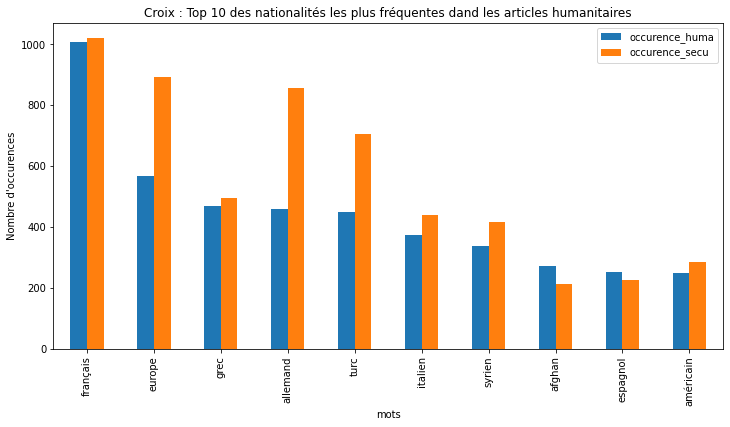

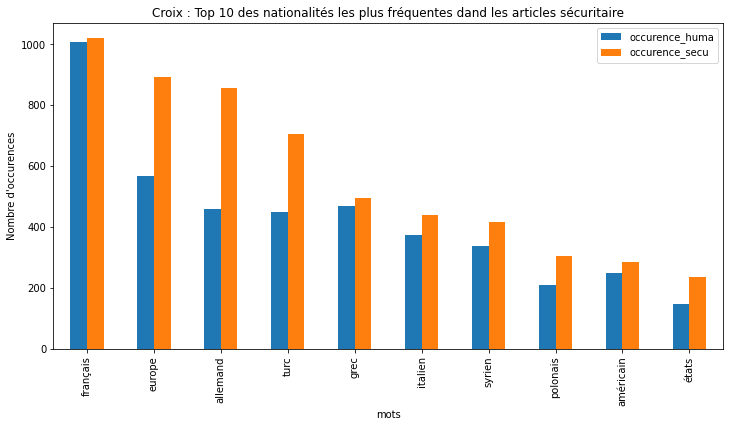

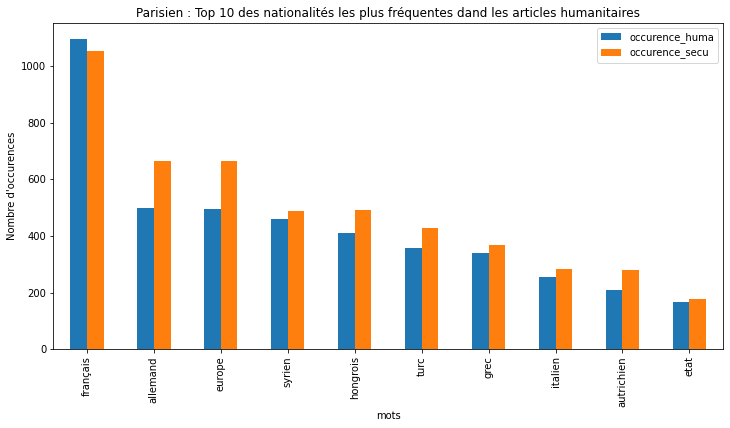

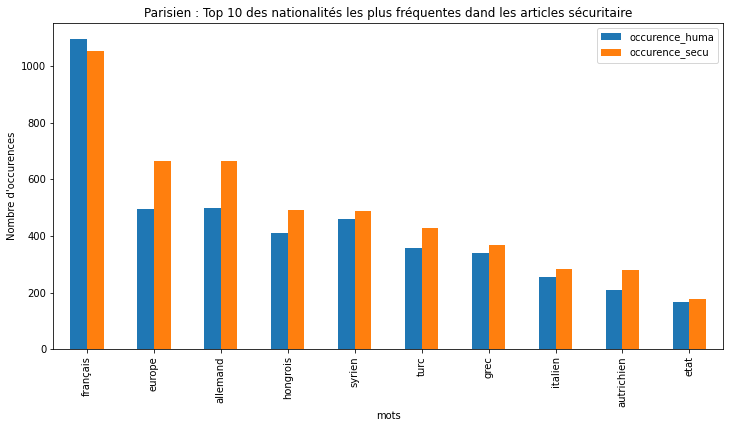

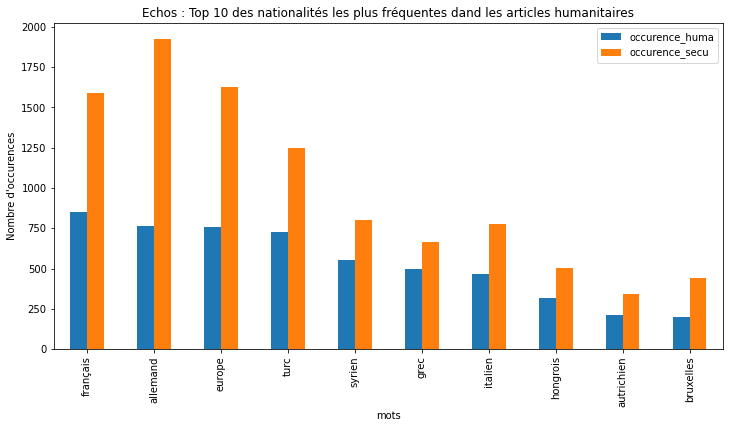

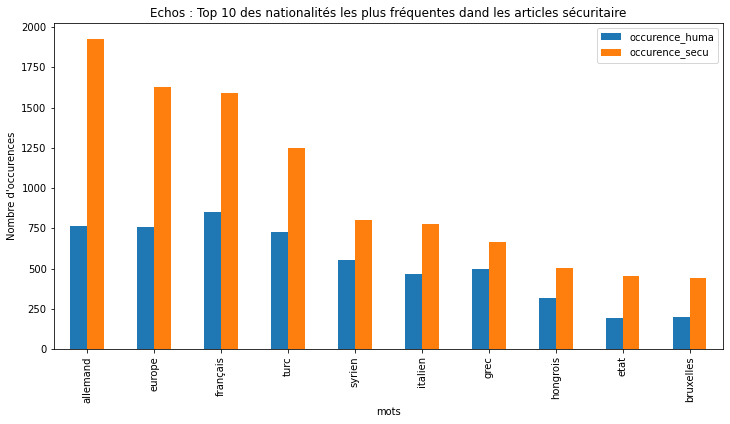

In [40]:
# Stat desc de l'occurence des nationalités dans les articles humanitaires et securitaire
word_to_eliminate = ["l'","la","de","-","l'","l'","l’","la","le"]
stat = stat.loc[~(stat.mots.isin(word_to_eliminate))]
for journal in stat.journal.unique():
    data = stat.loc[stat.journal==journal,["mots","occurence_huma","occurence_secu"]].groupby("mots").sum()
    
    data.sort_values("occurence_huma",ascending=False).head(10).plot(kind='bar', figsize=(12, 6))
    plt.title(f'{journal} : Top 10 des nationalités les plus fréquentes dand les articles humanitaires')
    plt.ylabel('Nombre d\'occurences')
    
    data.sort_values("occurence_secu",ascending=False).head(10).plot(kind='bar', figsize=(12, 6))
    plt.title(f'{journal} : Top 10 des nationalités les plus fréquentes dand les articles sécuritaire')
    plt.ylabel('Nombre d\'occurences')
    
    plt.show()

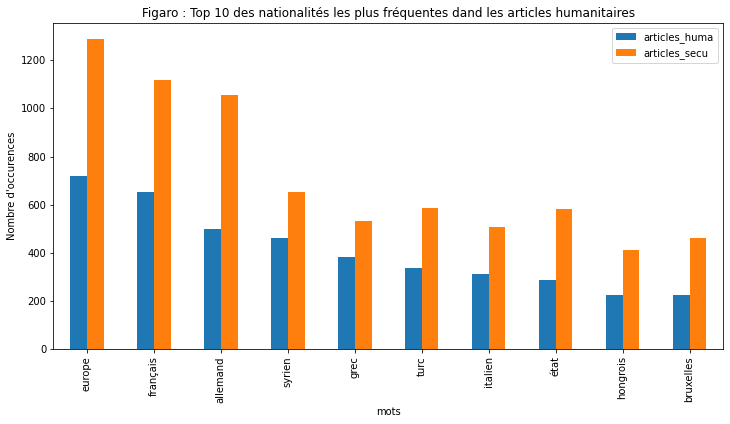

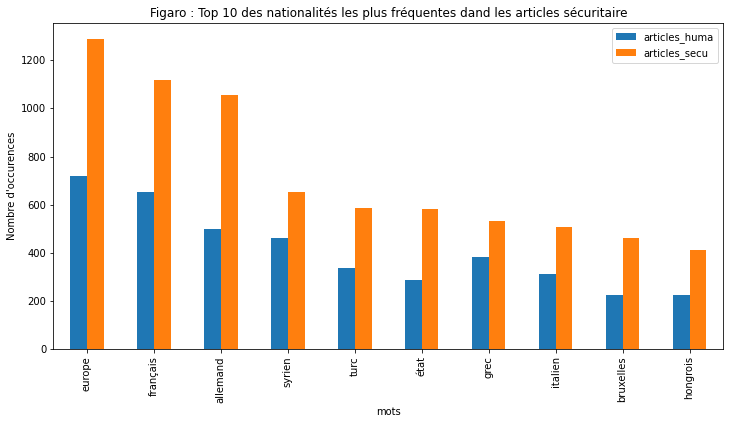

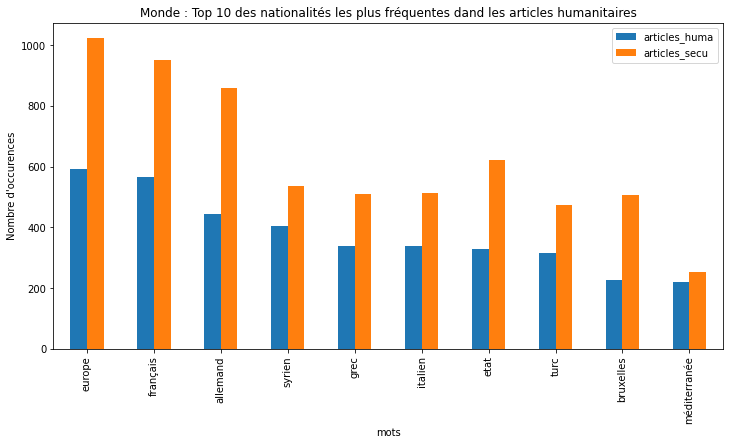

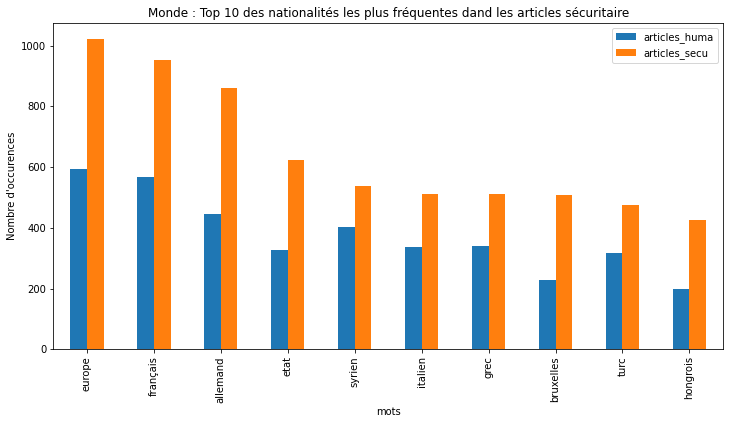

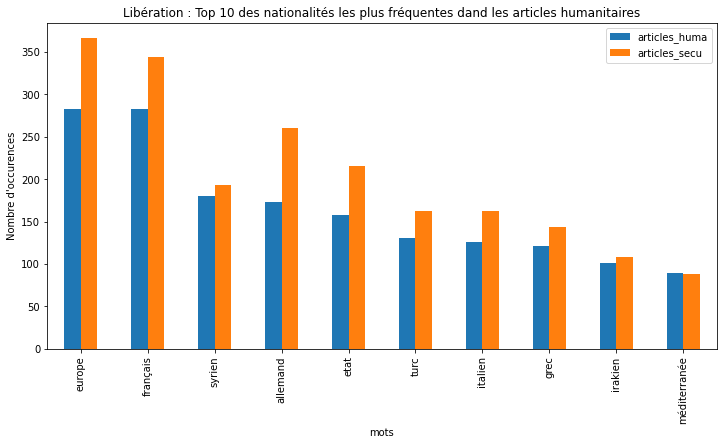

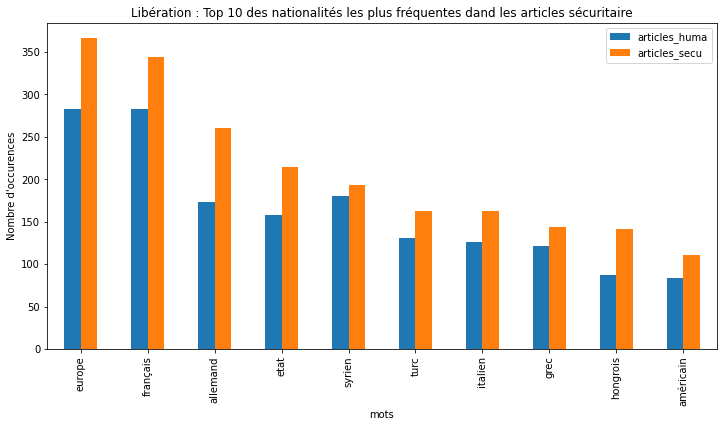

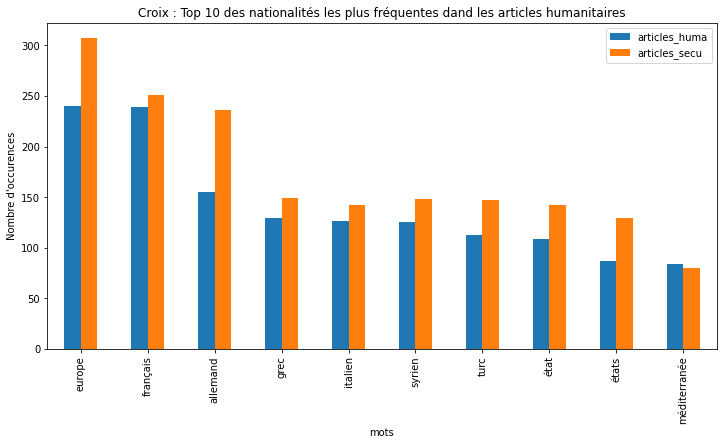

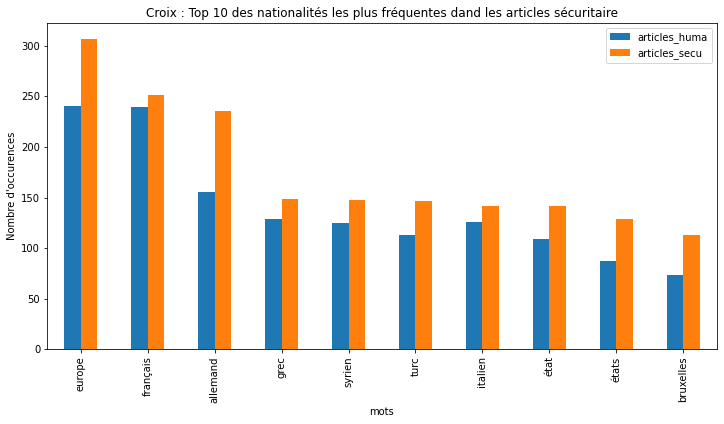

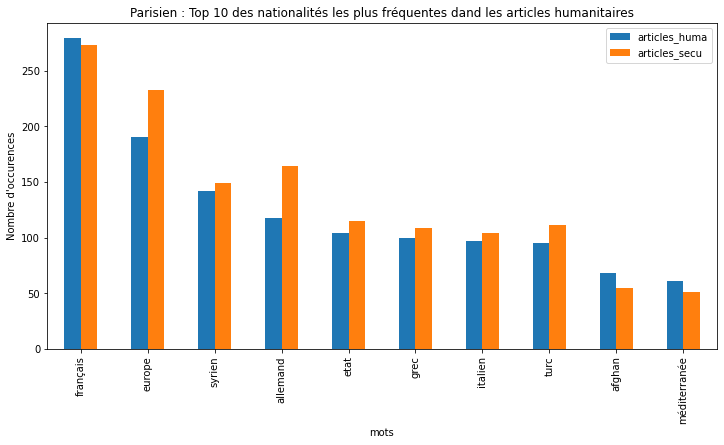

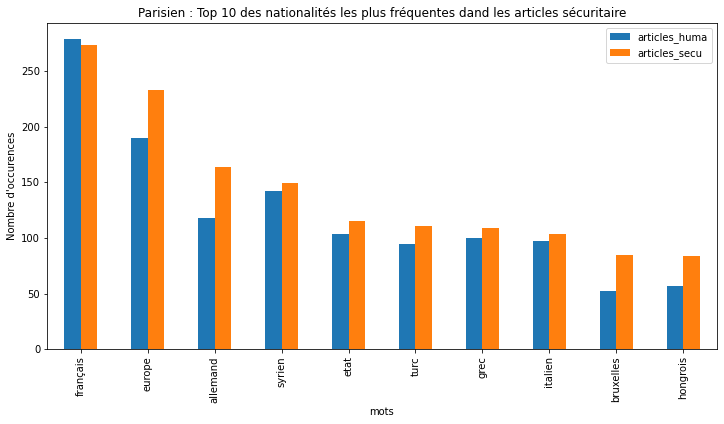

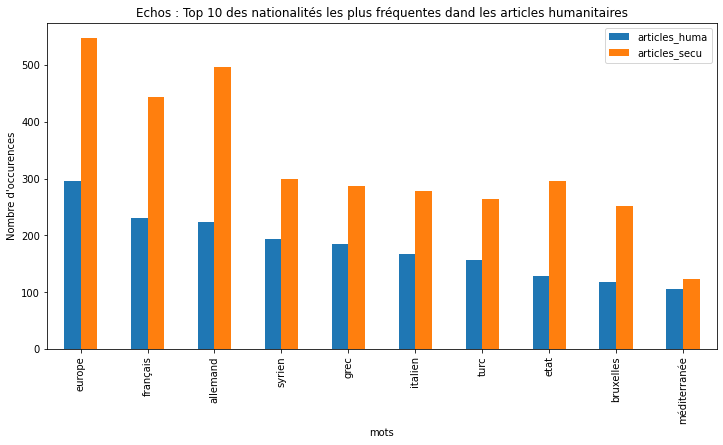

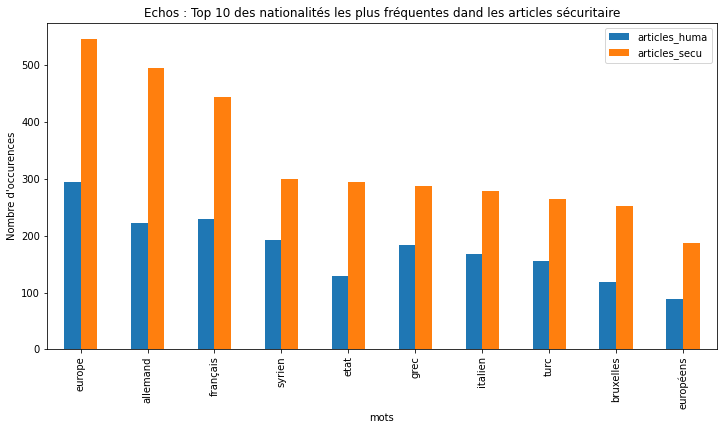

In [41]:
# Stat desc du nombre d'articles humanitaires et securitaire par nationalité
word_to_eliminate = ["l'","la","de","-","l'","l'","l’","la","le"]
stat = stat.loc[~(stat.mots.isin(word_to_eliminate))]
for journal in stat.journal.unique():
    data = stat.loc[stat.journal==journal,["mots","articles_huma","articles_secu"]].groupby("mots").sum()
    
    data.sort_values("articles_huma",ascending=False).head(10).plot(kind='bar', figsize=(12, 6))
    plt.title(f'{journal} : Top 10 des nationalités les plus fréquentes dand les articles humanitaires')
    plt.ylabel('Nombre d\'occurences')
    
    data.sort_values("articles_secu",ascending=False).head(10).plot(kind='bar', figsize=(12, 6))
    plt.title(f'{journal} : Top 10 des nationalités les plus fréquentes dand les articles sécuritaire')
    plt.ylabel('Nombre d\'occurences')
    
    plt.show()